## anomaly_detection
for all exercises

## Discrete data + probability

#### Techniques for identifying/detecting anomalies
#### Statistical Methods

In [1]:
from __future__ import division

import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from numpy import linspace, loadtxt, ones, convolve

import pandas as pd
from datetime import datetime
from dateutil.parser import parse

import math
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from random import randint

from matplotlib import style
import seaborn as sns
%matplotlib inline

import collections

# set default pandas decimal number display format and df display format:
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Wrangle Data

#### Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8])

In [3]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Parse Datetime

In [6]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [7]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [8]:
df['destination'].unique()

array([nan, '"https://python.zach.lol/api/V1/HiZach!"',
       '"https://python.zach.lol/api/v1/stores?page=0"',
       '"https://python.zach.lol/api/v1/stores?page=1"',
       '"https://python.zach.lol/api/v1/stores?page=2"',
       '"https://python.zach.lol/api/v1/stores?page=999"',
       '"https://python.zach.lol/api/v1/items?page=0"',
       '"http://localhost:8889/notebooks/timeseries_acquisition.ipynb"',
       '"https://python.zach.lol/api/v1//api/v1/items?page=2"',
       '"https://python.zach.lol/api/v1//api/v1/items"',
       '"https://python.zach.lol/api/v1//api/v1/items/next_page"',
       '"https://python.zach.lol/api/v1/helloclass!"',
       '"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"',
       '"http://localhost:8888/notebooks/acquire.ipynb"',
       '"https://python.zach.lol/api/v1/sales?page=3"',
       '"https://ds.codeup.com/8.3_Acquire/"',
       '"https://python.zach.lol/"',
       '"https://python.zach.lol/api/v1/items"',
       '"https://python.zach.lol/a

In [9]:
df.request_method.nunique()

220

#### Clean up text

These two steps below help to "normalize" the data by removing a bunch of distinct but unnecessary items, like the page numbers etc.  This will reduce the MANY distinct items down to a handful of distinct items.  Makes this easier, and REDUCES THE NOISE!

In [10]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [11]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
# this finds the "question mark\page=number" and this finds the literal word "page", and then find the equal sign,
# then find a numerical value, and it's repeated a number of times, hence the plus sign.

In [12]:
df.head(10)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,NaN,python-requests/2.21.0
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,NaN,python-requests/2.21.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,NaN,python-requests/2.21.0


In [13]:
df.request_method.nunique()

22

#### Add variable: converting bytes to mb

In [14]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df.describe()

,status,size,size_mb
count,"13,978.00","13,978.00","13,978.00"
mean,200.36,"450,001.91",0.43
std,10.18,"161,491.47",0.15
min,200.00,0.00,0.00
25%,200.00,"500,637.00",0.48
50%,200.00,"510,138.00",0.49
75%,200.00,"511,291.00",0.49
max,499.00,"2,056,327.00",1.96


In [15]:
df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/items/HTTP/1.1  

In [16]:
df.request_method.value_counts(dropna=False)/df.request_method.count()

GET /api/v1/sales HTTP/1.1                                     0.89
GET /api/v1/items HTTP/1.1                                     0.08
GET /api/v1/stores HTTP/1.1                                    0.02
GET / HTTP/1.1                                                 0.01
GET /documentation HTTP/1.1                                    0.01
GET /favicon.ico HTTP/1.1                                      0.00
GET /api/v1//api/v1/items HTTP/1.1                             0.00
GET /api/v1/items/api/v1/items HTTP/1.1                        0.00
GET /api/v1/items/next_page HTTP/1.1                           0.00
GET /api/v1/ HTTP/1.1                                          0.00
GET /api/v1/store HTTP/1.1                                     0.00
GET /api/v1/sales/HTTP/1.1                                     0.00
GET /api/v1/sales/ HTTP/1.1                                    0.00
GET /api/v1/itemsitems HTTP/1.1                                0.00
GET /api/v1items HTTP/1.1                       

In [17]:
df.request_agent.value_counts(dropna=False)/df.request_agent.count()

python-requests/2.21.0                                                                                                                      0.86
python-requests/2.20.1                                                                                                                      0.14
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                                          0.00
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                                  0.00
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                                0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36         

### Detecting Anomalies in Discrete Variables
#### Finding anomalies in already existing data
We can see easily some anomalies around various request_agents.

In [18]:
agent_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                       rename(index=str, columns={'index': 'request_agent','request_agent':'agent_count'})

agent_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_agent.count()).reset_index().\
                       rename(index=str, columns={'index': 'request_agent','request_agent':'agent_proba'})
agent_df = agent_df.merge(agent_df2)

In [19]:
agent_df.shape

(9, 3)

In [20]:
agent_df.head(20)

,request_agent,agent_count,agent_proba
0,python-requests/2.21.0,12005,0.86
1,python-requests/2.20.1,1911,0.14
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.00
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.00
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.00
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.00
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.00
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.00
8,Python-urllib/3.7,1,0.00


In [21]:
# see those where rate < 1% 
agent_df[agent_df.agent_proba < .01]

,request_agent,agent_count,agent_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.00
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.00
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.00
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.00
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.00
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.00
8,Python-urllib/3.7,1,0.00


In [22]:
print('Length of df:')
print(len(agent_df))
print('different distinct request_agents pinging the Zach_lol server.')
print('\n')
print('Tail of df:')
print('... the probabilities of those request_agents pinging that server:')
print('\n')
print(agent_df.tail(10))
print('\n')
print('Combining the first two request_agent probabilities, this means greater than 99.55% of the probability of hitting this server falls into the two types of python requests, 2.21 and 2.20.\n')
print('\n')
print('This means, most anything hitting this server that is NOT a python 2.20 and 2.21 request, is likely an anomaly or an outlier, for good or bad.')


Length of df:
9
different distinct request_agents pinging the Zach_lol server.


Tail of df:
... the probabilities of those request_agents pinging that server:


                                       request_agent  agent_count          agent_proba
0                             python-requests/2.21.0        12005                 0.86
1                             python-requests/2.20.1         1911                 0.14
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...           34                 0.00
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...            8                 0.00
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...            7                 0.00
5       Slackbot 1.0 (+https://api.slack.com/robots)            6                 0.00
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            4                 0.00
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            2                 0.00
8                                  Python-urllib/3.7   

### Plotting the request_agent numbers:

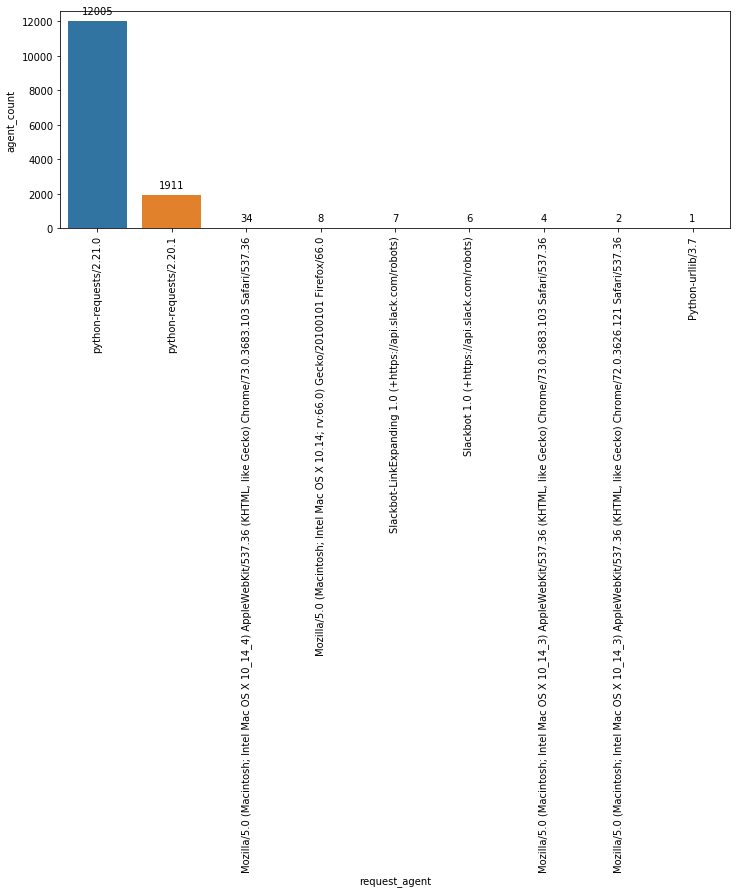

In [23]:
plt.figure(figsize=(12,4))
splot = sns.barplot(data=agent_df, x = 'request_agent', y = 'agent_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives
#### Establish baseline

In [24]:
df.shape

(13978, 7)

In [25]:
df.columns

Index(['ip', 'request_method', 'status', 'size', 'destination', 'request_agent', 'size_mb'], dtype='object')

In [26]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.49
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.00
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.49
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.49
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.49


In [27]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

#### Compute probabilities based on train sample

In [28]:
agent_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [29]:
agent_df.head(20)

,request_agent,agent_proba
0,python-requests/2.21.0,0.86
1,python-requests/2.20.1,0.14
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.00
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.00
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.00
5,Slackbot 1.0 (+https://api.slack.com/robots),0.00
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.00
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.00
8,Python-urllib/3.7,0.00


### Merge probabilities with all data (train + new data)
#### Where the ip address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [30]:
df = df.reset_index().merge(agent_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')

In [31]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.49,0.86
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.00,0.86
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.49,0.86
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.49,0.86
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.49,0.86


In [32]:
df.agent_proba.value_counts()

0.86    12005
0.14     1911
0.00       34
0.00        8
0.00        7
0.00        6
0.00        4
0.00        2
0.00        1
Name: agent_proba, dtype: int64

### Conditional Probabilities: probabilities using 2 discrete variables
#### Probability of destination given request_agent:
If we are looking for an unexpected destination (like weird website, etc) from a known/common request agent.

In [33]:
train.groupby('request_agent').size()
# this is the count by request_agent

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36        2
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Python-urllib/3.7                                                                                                                1
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
python-requests/2.20.1                                               

In [34]:
train.groupby('request_agent').size().div(len(df))
# this is the probability of the distinct request_agent items by the total data frame

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                                          0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Python-urllib/3.7                                                                                                                           0.00
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                                0.00
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                          

In [35]:
# now dividing the size, above, by the length of the df
# This is a repeat of the above cell, except setting a new data frame with these items and probs:
request_probs = train.groupby('request_agent').size().div(len(df))
request_probs

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                                          0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Python-urllib/3.7                                                                                                                           0.00
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                                0.00
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                          

In [36]:
destination_given_agent = pd.DataFrame(train.groupby(['request_agent', 'destination']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_destination_given_agent'})
                              )

In [37]:
destination_given_agent.head(40)

,request_agent,destination,proba_destination_given_agent
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://ds.codeup.com/8.3_Acquire/,0.50
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8888/notebooks/acquire.ipynb,0.03
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8889/notebooks/timeseries_acq...,0.03
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://ds.codeup.com/8.3_Acquire/,0.03
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/,0.03
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/api/V1/HiZach!,0.03
8,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/api/v1/,0.06
9,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/api/v1//api/v1/items,0.03


In [38]:
agent_destination_count = pd.DataFrame(train.groupby(['request_agent', 'destination'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_destination_count'}))

In [39]:
agent_destination_count.agent_destination_count.nunique()

2

In [40]:
df.request_method.unique()

array(['GET /api/v1/sales HTTP/1.1', 'GET /api/v1/items HTTP/1.1',
       'GET /api/v1/stores HTTP/1.1', 'GET / HTTP/1.1',
       'GET /documentation HTTP/1.1', 'GET /api/V1/HiZach! HTTP/1.1',
       'GET /favicon.ico HTTP/1.1',
       'GET /api/v1/items/next_page HTTP/1.1', 'GET /api/v1/ HTTP/1.1',
       'GET /api/v1//api/v1/items HTTP/1.1',
       'GET /api/v1//api/v1/items/next_page HTTP/1.1',
       'GET /api/v1items HTTP/1.1', 'GET /api/v1 HTTP/1.1',
       'GET /api/v1/items/api/v1/items HTTP/1.1',
       'GET /api/v1/helloclass! HTTP/1.1',
       'GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1',
       'GET /api/v1/itemsitems HTTP/1.1',
       'GET /api/v1/items&page=0 HTTP/1.1', 'GET /api/v1/sales/ HTTP/1.1',
       'GET /api/v1/store HTTP/1.1', 'GET /api/v1/items/HTTP/1.1',
       'GET /api/v1/sales/HTTP/1.1'], dtype=object)

In [41]:
agent_destination = destination_given_agent.merge(agent_destination_count)

In [42]:
agent_destination.head()

,request_agent,destination,proba_destination_given_agent,agent_destination_count
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50,1
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://ds.codeup.com/8.3_Acquire/,0.50,2
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50,2
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8888/notebooks/acquire.ipynb,0.03,1
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8889/notebooks/timeseries_acq...,0.03,1


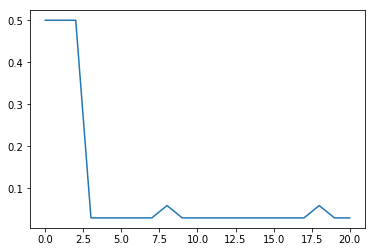

In [43]:
plt.plot(agent_destination.proba_destination_given_agent)

### Add these probabilities to original events to detect anomalous events

In [44]:
df = df.reset_index().merge(agent_destination, on=['request_agent', 'destination'], how='left').fillna(value=0).set_index('timestamp')

In [45]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_destination_given_agent,agent_destination_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.49,0.86,0.00,0.00
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.00,0.86,0.00,0.00
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.49,0.86,0.00,0.00
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.49,0.86,0.00,0.00
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.49,0.86,0.00,0.00


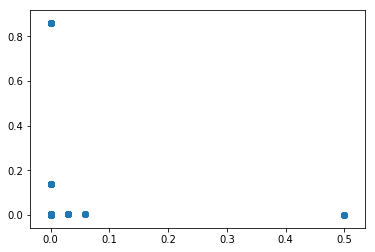

In [46]:
plt.scatter(df.proba_destination_given_agent, df.agent_proba)

## Time series + EMA

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.
- What would the dataframe look like?
- Use time series method for detecting anomalies, like exponential moving average with %b.
- See (paper) notes for good details on how to do this, to include graphics and images, as well as the previous lesson, named:
- ("anomaly_detection_lesson_29Apr19_timeseries_anomalies.ipynb" in same folder)

## Review Maggie's walkthrough here... it calculates number of distinct users w/page view per day per cohort.

#### she calculates the following:
over 7 days

for each cohort per day:
- EMA
- upper bound (ub)
- lower bound (lb)
- actual value
- % bound

(current - lb) / divided by / (ub - lb)

#### Bringing in data from csv

In [47]:
colnames=['date', 'page_viewed', 'user_id', 'cohort', 'ip']
df_orig = pd.read_csv('/Users/rachelreuter/ds-methodologies/anomaly_detection/anonymized-curriculum-access.txt',
    header=None,
    index_col=False,
    names=colnames,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    na_values='"-"',
    usecols=[0,2,3,4,5]
)

In [48]:
df_orig = df_orig.dropna()
df_orig.cohort = df_orig.cohort.astype('int')
print(df_orig.info())
df_orig.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort         219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB
None


,date,page_viewed,user_id,cohort,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


#### Bringing in the Codeup cohort names, for use later

In [49]:
colnames=['cohort_name','cohort']
df_cohort = pd.read_csv('cohort_id_name.txt',
                       names=colnames, 
                       skiprows=1)
print(df_cohort.info())
df_cohort.head(32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
cohort_name    31 non-null object
cohort         31 non-null int64
dtypes: int64(1), object(1)
memory usage: 576.0+ bytes
None


,cohort_name,cohort
0,Arches,1
1,Badlands,2
2,Carlsbad,3
3,Denali,4
4,Everglades,5
5,Franklin,6
6,Glacier,7
7,Hampton,8
8,Apollo,9
9,Balboa,10


#### Merging the Codeup cohort names with the df, into one df.

In [50]:
df = df_orig.merge(df_cohort, on='cohort', how='left')
df.head()

,date,page_viewed,user_id,cohort,ip,cohort_name
0,2018-01-26,/,1,8,97.105.19.61,Hampton
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy


#### Looking at shape, columns, dtypes and description of data

In [51]:
df.shape

(219070, 6)

In [52]:
df.columns

Index(['date', 'page_viewed', 'user_id', 'cohort', 'ip', 'cohort_name'], dtype='object')

In [53]:
#df.dtypes

In [54]:
df.describe()

,user_id,cohort
count,"219,070.00","219,070.00"
mean,185.75,23.12
std,107.37,5.87
min,1.00,1.00
25%,105.00,22.00
50%,199.00,24.00
75%,272.00,26.00
max,398.00,31.00


#### Combining date and time into one field

In [55]:
# df_orig['dateandtime'] = df_orig['date'] + ' ' + df_orig['time']

In [56]:
# df_orig.head()

- Success

#### Changing that new combined dateandtime field to datetime format

In [57]:
df['date'] = pd.to_datetime(df.date)
df = df.dropna()

In [58]:
# df_orig['dateandtime'] = pd.to_datetime(df_orig['dateandtime'])

In [59]:
#df_orig['date'] = pd.to_datetime(df_orig['date'])

In [60]:
df.dtypes

date           datetime64[ns]
page_viewed            object
user_id                 int64
cohort                  int64
ip                     object
cohort_name            object
dtype: object

In [61]:
df.shape

(219070, 6)

- Success

#### Checking the dataframe for blanks, nulls, missing, Nan, etc

In [62]:
def missing_values_col(df):
	"""
	Write or use a previously written function to return the
	total missing values and the percent missing values by column.
	"""
	null_count = df.isnull().sum()
	null_percentage = (null_count / df.shape[0]) * 100
	empty_count = pd.Series(((df == ' ') | (df == '')).sum())
	empty_percentage = (empty_count / df.shape[0]) * 100
	nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
	nan_percentage = (nan_count / df.shape[0]) * 100
	return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
	                     'num_empty': empty_count, 'empty_percentage': empty_percentage,
	                     'nan_count': nan_count, 'nan_percentage': nan_percentage})

In [63]:
missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
date,0,0.00,0,0.00,0,0.00
page_viewed,0,0.00,0,0.00,0,0.00
user_id,0,0.00,0,0.00,0,0.00
cohort,0,0.00,0,0.00,0,0.00
ip,0,0.00,0,0.00,0,0.00
cohort_name,0,0.00,0,0.00,0,0.00


In [64]:
def peekatdata(df):
    print("\n \n SHAPE:")
    print(df.shape)

    print("\n \n COLS:")
    print(df.columns)

    print("\n \n INFO:")
    print(df.info())

    print("\n \n Missing Values:")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())

    print("\n \n DESCRIBE:")
    print(df.describe())

    print('\n \n HEAD:')
    print(df.head(5))

    print('\n \n TAIL:' )
    print(df.tail(5))

In [65]:
peekatdata(df)


 
 SHAPE:
(219070, 6)

 
 COLS:
Index(['date', 'page_viewed', 'user_id', 'cohort', 'ip', 'cohort_name'], dtype='object')

 
 INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 219069
Data columns (total 6 columns):
date           219070 non-null datetime64[ns]
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort         219070 non-null int64
ip             219070 non-null object
cohort_name    219070 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.7+ MB
None

 
 Missing Values:
date           0
page_viewed    0
user_id        0
cohort         0
ip             0
cohort_name    0
dtype: int64

 
 DESCRIBE:
                   user_id               cohort
count           219,070.00           219,070.00
mean                185.75                23.12
std                 107.37                 5.87
min                   1.00                 1.00
25%                 105.00                22.00
50%         

#### Filling in any Nans with zero

In [66]:
#df_orig = df_orig.fillna(0)

In [67]:
#df_orig[['cohort']] = df_orig[['cohort']].astype(int)

In [68]:
#df_orig[['cohort']] = df_orig[['cohort']].astype(str)

In [69]:
#df_orig[['student_id']] = df_orig[['student_id']].astype(str)

In [70]:
# df_orig = field_drop(df_orig)

In [71]:
#df_orig = df_orig[['date','dateandtime','ip','cohort','student_id','curriculum_topic']]

##### Dataframe now appears to be ready to review.  Will check with .describe.

In [72]:
df.describe(include='all')

,date,page_viewed,user_id,cohort,ip,cohort_name
count,219070,219070,"219,070.00","219,070.00",219070,219070
unique,432,964,nan,nan,1605,26
top,2018-08-17 00:00:00,/,nan,nan,97.105.19.58,Voyageurs
freq,1760,10862,nan,nan,97764,34485
first,2018-01-26 00:00:00,NaN,nan,nan,NaN,NaN
last,2019-04-02 00:00:00,NaN,nan,nan,NaN,NaN
mean,NaN,NaN,185.75,23.12,NaN,NaN
std,NaN,NaN,107.37,5.87,NaN,NaN
min,NaN,NaN,1.00,1.00,NaN,NaN
25%,NaN,NaN,105.00,22.00,NaN,NaN


#### Dataframe is prepared and ready to proceed with the anomaly detection lesson.

#### Reiterate the lesson objective:

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.
- What would the dataframe look like?
- Use time series method for detecting anomalies, like exponential moving average with %b.
- See (paper) notes for good details on how to do this, to include graphics and images, as well as the previous lesson:
- ("anomaly_detection_lesson_29Apr19_timeseries_anomalies.ipynb" in same folder)

#### Creating a new AGGREGATED dataframe grouped by date, cohort and cohort name, and counting instances of user IDs, for that combination of cohort and cohort name ON THAT DATE.

In [73]:
df_agg = df.groupby(['date','cohort','cohort_name'])['user_id'].\
nunique().\
reset_index().\
rename(index=str, columns={'user_id': 'users_viewed'})


# df_agg = df.groupby(['date','cohort_id','cohort_name'])['user_id'].\
#                         nunique().\
#                     reset_index().\
#                     rename(index=str, 
#                        columns={'user_id': 'users_viewed'})

In [74]:
df_agg.tail()

,date,cohort,cohort_name,users_viewed
3361,2019-04-02,26,Xanadu,2
3362,2019-04-02,27,Yosemite,2
3363,2019-04-02,28,Staff,5
3364,2019-04-02,29,Zion,22
3365,2019-04-02,31,Andromeda,20


In [75]:
df_agg.shape

(3366, 4)

In [76]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
cohort          3366 non-null int64
cohort_name     3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB


#### she calculates the following:
over 7 days

for each cohort per day:
- EMA
- upper bound (ub)
- lower bound (lb)
- actual value
- % bound

(current - lb) / divided by / (ub - lb)

### EMA

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA, or Simple Moving Average. It does this by putting more weight on more recent observations, whereas the SMA weights all observations equally.

#### First, create separate list of Codeup class cohorts to use later

In [77]:
cohorts = list(df_agg.cohort_name.unique())
cohorts

['Arches',
 'Hampton',
 'Kings',
 'Niagara',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Teddy',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda']

#### Then, set the index to date on the AGGREGATED df, and rename 'users_viewed' field to 'ema', or 'Exponential Moving Average'.

Again, the Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA, or Simple Moving Average. It does this by putting more weight on more recent observations, whereas the SMA weights all observations equally.

In [78]:
df = df_agg.set_index('date').\
rename(index=str, columns={'users_viewed':'ema'}).\
drop(columns='cohort')

# df = df_agg.set_index('date').\
#             rename(index=str, columns={'users_viewed':'ema'}).\
#             drop(columns='cohort_id')

In [79]:
df.head()

,cohort_name,ema
date,,
2018-01-26 00:00:00,Arches,1
2018-01-26 00:00:00,Hampton,1
2018-01-26 00:00:00,Kings,1
2018-01-26 00:00:00,Niagara,2
2018-01-26 00:00:00,Pinnacles,1


#### Now create the Bollinger bands, and setting a standard deviation rolling average (EMA, see further below) of 14 days:

Bollinger bands are created by multiplying plus or minus three standard deviations.  The upper bounds and lower bounds are created from the standard deviation.  For lag days inside that initial 14-day rolling window, nans will initially be created, but will be filled in later... see code later for further details.

In [80]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev * 3
    ema['lb'] = ema.ema - ema.stdev * 3
    return ema.reset_index()

#### Now create new 'bb' df by calling that bollinger_bands() function on the original 'df', where the df.cohort_name matches the list of cohort names, created just above this cell, at the start of the "EMA" section.

#### Now feed that bb df into an empty list called bands... then concat that list into a new df called 'df2'

In [81]:
bands = []
for cohort in cohorts:
    bb = bollinger_bands(df[df.cohort_name == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

# bands = []
# for cohort in cohorts:
#     bb = bollinger_bands(df[df.cohort_name == cohort])
#     bands.append(bb)

# df2 = pd.concat(bands)

In [82]:
df2.head()

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.00,nan,nan,nan
1,2018-01-29 00:00:00,Arches,1.27,nan,nan,nan
2,2018-01-30 00:00:00,Arches,1.36,nan,nan,nan
3,2018-01-31 00:00:00,Arches,1.45,nan,nan,nan
4,2018-02-01 00:00:00,Arches,1.39,nan,nan,nan


#### Notice the stdev, ub and lb fields in df2 immediately above.  Check for null or nan values:

In [83]:
df2.isnull().sum()

date             0
cohort_name      0
ema              0
stdev          298
ub             298
lb             298
dtype: int64

#### Now start to deal with those nans by creating yet another df containing the fields 'cohort_name' and 'ema' from df2, by looking at df2, specifically where the stdev field in df2 is null.

In [84]:
df_missing = df2[df2.stdev.isnull()][['cohort_name','ema']]
df_missing.head()

,cohort_name,ema
0,Arches,1.00
1,Arches,1.27
2,Arches,1.36
3,Arches,1.45
4,Arches,1.39


#### Now group the new df_missing df on field 'cohort_name', and fill in the missing stdevs with zero, reset the index, and finally, rename the 'ema' field to 'stdev_null'.

#### This groups/aggs the stdevs for all items in each cohort name.

#### ...And creates a stdev for any cohort/day where the stdev may be missing, due to the lag days involved in using EMA, in this case 14 days.

In [85]:
df_missing = df_missing.groupby('cohort_name').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})

In [86]:
df_missing.head(31)

,cohort_name,stdev_null
0,Andromeda,3.42
1,Apollo,0.00
2,Arches,0.21
3,Badlands,0.00
4,Denali,0.00
5,Franklin,0.00
6,Glacier,0.00
7,Hampton,0.00
8,Ike,0.00
9,Joshua,0.00


#### Now merge the df_missing immediately above (containing the 'missing' stdev values for each cohort) with the df2 from further above, containing the Bollinger Bands for each cohort, for each date.

#### Merge this into a new df, merging on 'cohort_name'.

In [87]:
df = df2.merge(df_missing, on='cohort_name', how='left')

In [88]:
df.tail(15)

,date,cohort_name,ema,stdev,ub,lb,stdev_null
3351,2019-03-19 00:00:00,Andromeda,6.40,nan,nan,nan,3.42
3352,2019-03-20 00:00:00,Andromeda,8.35,nan,nan,nan,3.42
3353,2019-03-21 00:00:00,Andromeda,10.03,nan,nan,nan,3.42
3354,2019-03-22 00:00:00,Andromeda,11.50,nan,nan,nan,3.42
3355,2019-03-23 00:00:00,Andromeda,10.36,nan,nan,nan,3.42
3356,2019-03-24 00:00:00,Andromeda,9.65,nan,nan,nan,3.42
3357,2019-03-25 00:00:00,Andromeda,11.29,nan,nan,nan,3.42
3358,2019-03-26 00:00:00,Andromeda,12.72,nan,nan,nan,3.42
3359,2019-03-27 00:00:00,Andromeda,13.96,nan,nan,nan,3.42
3360,2019-03-28 00:00:00,Andromeda,15.03,nan,nan,nan,3.42


#### Now, use idx as the index to find where in the df the stdev field is null.
 
#### Then after locating those null rows/records in the stdev field, now fill them with the value in the stdev_null field that we just created above.  Then, afterward, drop the stdev_null field, as it's no longer needed.

In [89]:
idx = df.stdev.isnull()
df.loc[idx,'stdev'] = df.loc[idx,'stdev_null']
df = df.drop(columns='stdev_null')

In [90]:
df.head()

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.00,0.21,nan,nan
1,2018-01-29 00:00:00,Arches,1.27,0.21,nan,nan
2,2018-01-30 00:00:00,Arches,1.36,0.21,nan,nan
3,2018-01-31 00:00:00,Arches,1.45,0.21,nan,nan
4,2018-02-01 00:00:00,Arches,1.39,0.21,nan,nan


#### Note, the nans in the stdev field above have been filled in accordingly.

#### Now, same routine with the upper and lower bound fields.  These will be filled in with the stdev-calculated formulas shown below:

#### First locate the null values in the ub field and label with idx.  Then use idx to locate and populate both ub and lb nulls accordingly.

In [91]:
idx = df.ub.isnull()
df.loc[idx,'ub'] = df.loc[idx,'ema'] + df.loc[idx,'stdev']*3
df.loc[idx,'lb'] = df.loc[idx,'ema'] - df.loc[idx,'stdev']*3

In [92]:
df.head(3)

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.00,0.21,1.64,0.36
1,2018-01-29 00:00:00,Arches,1.27,0.21,1.90,0.63
2,2018-01-30 00:00:00,Arches,1.36,0.21,2.00,0.73


In [93]:
df.tail(3)

,date,cohort_name,ema,stdev,ub,lb
3363,2019-03-31 00:00:00,Andromeda,13.31,3.34,23.34,3.29
3364,2019-04-01 00:00:00,Andromeda,14.34,2.72,22.50,6.18
3365,2019-04-02 00:00:00,Andromeda,15.09,2.33,22.07,8.11


In [94]:
df.isnull().sum()

date           0
cohort_name    0
ema            0
stdev          0
ub             0
lb             0
dtype: int64

#### Note, the nulls in stdev, ub and lb in df above are all populated... moving on to next steps.

Some ub and lb values may be equal in a given row if the ema is equal to 1.  See below for example.

This is an error and must be fixed:

In [95]:
df[df.ub == df.lb].count()

date           79
cohort_name    79
ema            79
stdev          79
ub             79
lb             79
dtype: int64

In [96]:
df[df.ub == df.lb]

,date,cohort_name,ema,stdev,ub,lb
264,2018-01-26 00:00:00,Hampton,1.00,0.00,1.00,1.00
265,2018-01-27 00:00:00,Hampton,1.00,0.00,1.00,1.00
266,2018-01-29 00:00:00,Hampton,1.00,0.00,1.00,1.00
267,2018-01-30 00:00:00,Hampton,1.00,0.00,1.00,1.00
268,2018-01-31 00:00:00,Hampton,1.00,0.00,1.00,1.00
269,2018-02-01 00:00:00,Hampton,1.00,0.00,1.00,1.00
270,2018-02-02 00:00:00,Hampton,1.00,0.00,1.00,1.00
271,2018-02-04 00:00:00,Hampton,1.00,0.00,1.00,1.00
272,2018-02-05 00:00:00,Hampton,1.00,0.00,1.00,1.00
273,2018-02-06 00:00:00,Hampton,1.00,0.00,1.00,1.00


#### This is an error and must be fixed.

#### First locate those rows, then nudge each up or down accordingly (if ub or lb, respectively) by .01 to correct.

In [97]:
idx = df.ub == df.lb
df.loc[idx,'ub'] = df.loc[idx,'ub'] + .01
df.loc[idx,'lb'] = df.loc[idx,'lb'] - .01

##### Now verify the fix worked.

In [98]:
df[df.ub == df.lb].count()

date           0
cohort_name    0
ema            0
stdev          0
ub             0
lb             0
dtype: int64

##### Issue above has been fixed.

#### Now reset the date field in the df to datetime datatype:

In [99]:
df.date = pd.to_datetime(df.date)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 6 columns):
date           3366 non-null datetime64[ns]
cohort_name    3366 non-null object
ema            3366 non-null float64
stdev          3366 non-null float64
ub             3366 non-null float64
lb             3366 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 184.1+ KB


#### Remember the AGGREGATED df_agg df from above, that contained groupings by date, cohort and cohort name, and counted instances of user IDs, for that combination of cohort and cohort name ON THAT DATE?

#### Let's pull it back up and look at its info... in preparation for merging.

In [101]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
cohort          3366 non-null int64
cohort_name     3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB


#### Now merge the df from above with the aggregated df_agg immediately above:

In [102]:
# join with aggregated dataset to get the original count of users viewed
df = df.merge(df_agg, on=['cohort_name','date'], how='left')

In [103]:
df.head()

,date,cohort_name,ema,stdev,ub,lb,cohort,users_viewed
0,2018-01-26,Arches,1.00,0.21,1.64,0.36,1,1
1,2018-01-29,Arches,1.27,0.21,1.90,0.63,1,3
2,2018-01-30,Arches,1.36,0.21,2.00,0.73,1,2
3,2018-01-31,Arches,1.45,0.21,2.09,0.81,1,2
4,2018-02-01,Arches,1.39,0.21,2.03,0.75,1,1


#### Now compute the %b:

In [104]:
# compute %b
df['pct_b'] = (df.users_viewed - df.lb)/(df.ub - df.lb)

In [105]:
df = df.drop(columns=['stdev','cohort'])

In [106]:
df.head()

,date,cohort_name,ema,ub,lb,users_viewed,pct_b
0,2018-01-26,Arches,1.00,1.64,0.36,1,0.50
1,2018-01-29,Arches,1.27,1.90,0.63,3,1.86
2,2018-01-30,Arches,1.36,2.00,0.73,2,1.00
3,2018-01-31,Arches,1.45,2.09,0.81,2,0.93
4,2018-02-01,Arches,1.39,2.03,0.75,1,0.19


#### Now sort all pct_b values "descending", looking for outliers above the 1.0 ub.

In [107]:
df[df.pct_b>1].sort_values(by='pct_b', ascending=False)

,date,cohort_name,ema,ub,lb,users_viewed,pct_b
2286,2018-11-05,Ulysses,1.91,2.26,1.56,5,4.89
938,2018-07-11,Quincy,1.14,1.24,1.04,2,4.76
1799,2018-11-07,Lassen,1.14,1.24,1.04,2,4.75
1730,2018-08-20,Lassen,1.14,1.24,1.03,2,4.72
595,2018-11-19,Kings,1.28,1.49,1.08,3,4.72
2023,2019-02-22,Olympic,1.14,1.24,1.03,2,4.69
1705,2018-07-19,Lassen,1.14,1.24,1.03,2,4.67
727,2018-11-21,Niagara,1.14,1.24,1.03,2,4.66
285,2018-03-01,Hampton,1.13,1.24,1.03,2,4.55
1551,2019-02-27,Teddy,1.30,1.52,1.08,3,4.35


#### I can do the same with those pct_b values below the 0.0 lb.

In [108]:
df[df.pct_b<0].sort_values(by='pct_b', ascending=True)

,date,cohort_name,ema,ub,lb,users_viewed,pct_b
160,2018-08-18,Arches,2.64,2.87,2.41,1,-3.10
2678,2018-08-11,Wrangell,17.99,20.10,15.88,4,-2.82
2559,2018-11-10,Voyageurs,2.24,2.46,2.02,1,-2.31
2734,2018-10-06,Wrangell,13.96,15.79,12.14,4,-2.23
2741,2018-10-13,Wrangell,13.23,15.49,10.96,2,-1.98
2077,2018-03-30,Ulysses,15.93,18.56,13.30,3,-1.96
2755,2018-10-27,Wrangell,12.28,14.41,10.15,2,-1.91
3000,2019-03-06,Xanadu,3.50,4.03,2.96,1,-1.82
3317,2019-03-01,Zion,16.88,19.01,14.75,7,-1.81
131,2018-07-11,Arches,2.68,2.83,2.53,2,-1.78


#### Now plot out how this looks, with a rolling 7-day exponential moving average (EMA):

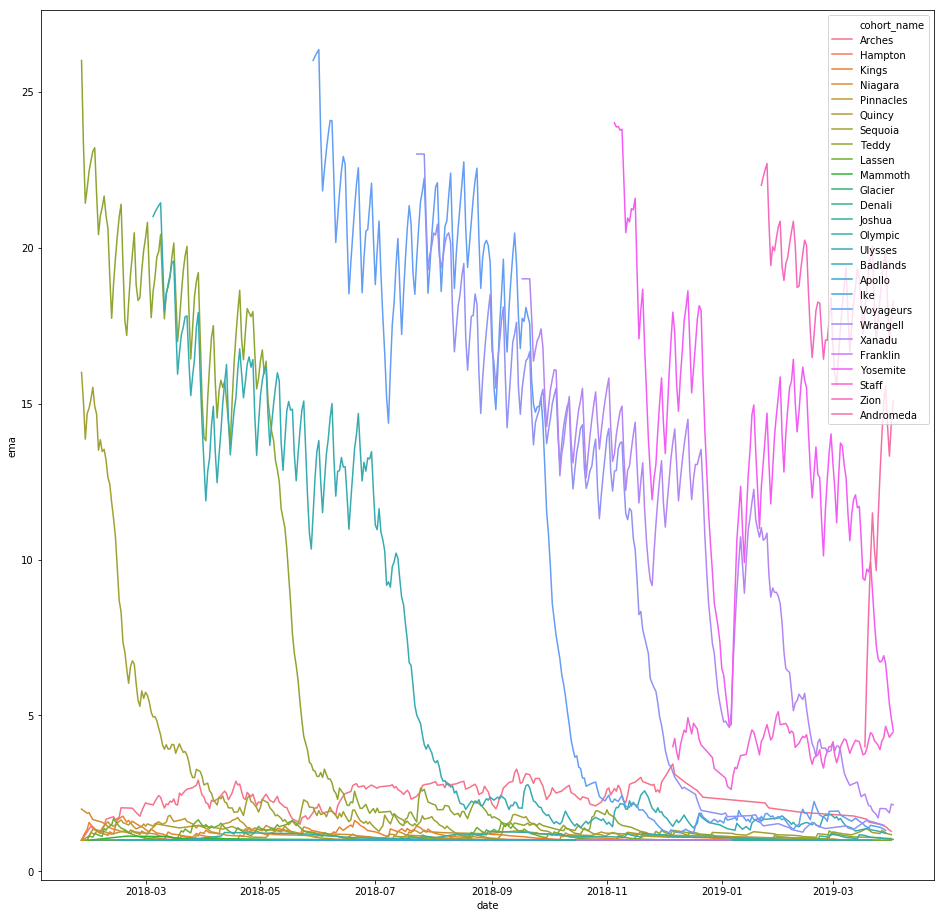

In [109]:
fig = plt.figure(figsize=(16,16))
sns.lineplot(df.date, df.ema, hue=df.cohort_name)


# fig = plt.figure(figsize=(16,16))
# sns.lineplot(df.date, df.ema, hue=df.cohort_name)

## Below is the work I was working through, prior to the walk through...

#### Note, MANY of the initial steps were removed and replaced with steps above.  The steps below are after all the manipulations to the df were done, and I was attempting to start grouping/aggregating, but having trouble.  

####  Just pick one cohort to do the grouping on, and then do the timeseries on that one grouped cohort.

In [ ]:
df = df_orig[df_orig.cohort == '0']

In [ ]:
df.shape

In [ ]:
df.describe(include='all')

In [ ]:
peekatdata(df)

In [ ]:
df['student_id'].unique()

In [ ]:
df.dtypes

In [ ]:
df['student_id'].max()

In [ ]:
df.head(10)

#### Resample to 30 minute intervals taking min of curriculum page visited

In [ ]:
monkey = df.groupby([df.index.date,'student_id']).count()

In [ ]:
monkey

In [ ]:
monkey2 = df['student_id'].resample('1D').count()

In [ ]:
df.groupby('student_id').size()

In [ ]:
monkey2

In [ ]:
df.groupby('curriculum_topic').describe()

In [ ]:
df.groupby(df.index.date).agg(['min','max','mean'])

In [ ]:
#df = df['curriculum_topic'].resample('30T').min()
df2 = df['curriculum_topic'].resample('30T').value_counts.min()

In [ ]:
df2

In [ ]:
idx = pd.date_range(
    df2.sort_index().index.min(), 
    df2.sort_index().index.max(),
    freq='30min'
)

In [ ]:
df2 = df2.reindex(idx, fill_value=0).fillna(value=0)

In [ ]:
df2

### This is preparing the data so we can look at the avg, SMA, EMA and %B.


In [ ]:
start_date_train = df2.head(1).index[0]

In [ ]:
end_date_train = '2019-03-15 23:30:00'

In [ ]:
start_date_test = '2019-03-16 00:00:00'

In [ ]:
train = df2[:end_date_train]
test = df2[start_date_test:]

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.show()

In [ ]:
# calculating upper and lower bands, Maggie provided in the slack channel:

span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband